#CMU-MoCap-load-dataset.ipynb
This is a loader for the CMU grand challenge dataset with motion capture for subjects making several recipes.

The data used is obtained from kitchen.cs.cmu.edu and the data collection was funded in part by the National Science Foundation under Grant No. EEEC-0540865.

http://kitchen.cs.cmu.edu/main.php

If you use this dataset in your work please follow the dataset authors' citation request [here](https://www.ri.cmu.edu/publications/guide-to-the-carnegie-mellon-university-multimodal-activity-cmu-mmac-database/).

This is work in progress and frequently updated, please check the repository at our [IMICS Lab Github repository](https://github.com/imics-lab/load_data_time_series) for the latest.  Much appreciation to Vangelis Metsis and Alex Katrompas for the [initial loader](https://git.txstate.edu/imics-lab/tattend/tree/main/scripts) from which multiple methods have been derived.

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

[Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  
TODO:
* A lot.  This version is early work.


In [1]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
import time
#import csv # probably not needed once download processes zip
import pandas as pd
import numpy as np
import tensorflow as tf
from numpy import savetxt
#from tabulate import tabulate # for verbose tables, showing data
from tensorflow.keras.utils import to_categorical # for one-hot encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from time import gmtime, strftime, localtime #for displaying Linux UTC timestamps in hh:mm:ss
from datetime import datetime, date, timedelta
import urllib.request # to get files from web w/o !wget
import zipfile

In [2]:
def get_web_file(fname, url):
    """checks for local file, if none downloads from URL.    
    :return: nothing"""
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from", url)
        urllib.request.urlretrieve(url, filename=fname)

# Load shared transform (xform) functions and utils

In [3]:
try:
    import load_data_transforms as xform
except:
    get_web_file(fname = 'load_data_transforms.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_transforms.py')
    import load_data_transforms as xform

try:
    import load_data_utils as utils  
except:
    get_web_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')
    import load_data_utils as utils

# Setup environment and dataset parameters

In [4]:
# environment and execution parameters
my_dir = '.' # replace with absolute path if desired
ir1_dir = 'cmu_ir1' # this is where the raw data IR1s will be stored
#working_dir = 'psg_temp'
# if not os.path.exists(working_dir):
#     os.mkdir(working_dir)
interactive = True # for exploring data and functions interactively
verbose = True

# dataset parameters
all_channel_list = [] # this will get populated from the IR1 dataframe column names
xform.time_steps = 500 # IR1 dataframes are set to 100Hz
xform.stride = 500 # how far to move for next window, if = times_steps no overlap
# The label_map_<dataset> contains a mapping from strings to ints for all
# possible labels in the entire dataset.   This allows for predictable conversion
# regardless of the slices.
label_map_psg = dict()

# setup a global readme so various methods can append info as needed
readme = 'This readme auto-generated by CMU-MoCap_load_dataset.ipynb\n'
readme += 'Executed on '
today = date.today()
readme += today.strftime("%B %d, %Y") + "\n"
readme += 'ref: https://github.com/imics-lab/load_data_time_series \n'

In [17]:
interactive = False # skip this cell, runs automatically for .py version

# CMU kitchen specific functions
Much appreciation to Vangelis Metsis and Alex Katrompas for the [initial loader](https://git.txstate.edu/imics-lab/tattend/tree/main/scripts) from which multiple methods have been derived.


In [5]:
df_labels = pd.DataFrame() # workaround to get a global
# Assign labels to each frame in the time synchronization data
def assign_label(frame_number, offset):
    for _, row in df_labels.iterrows():
        if row['start_frame'] <= frame_number - (offset - 1) <= row['end_frame']:
            return row['label']
    return 'unknown'

# Function to process the IMU data file
def process_data_file(file_path, archive):
    with archive.open(file_path) as f:
        # Get the sensor_ID from the first line of the file, e.g. "sensor_ID	2794"
        sensor_id = f.readline().decode('utf-8').split('\t')[1].strip()

        # Read the rest of the file into a Pandas DataFrame
        df = pd.read_csv(f, delim_whitespace=True)

    # Check if 'Count' column contains any string values
    if df['Count'].apply(lambda x: isinstance(x, str)).any():
        # Drop rows containing "ERROR_1--TIMEOUT" in the Count column
        df = df[~df['Count'].str.contains('ERROR')]

    # Convert SysTime to datetime object
    df['system_time'] = df['SysTime'].str.replace('_', ':')
    df['system_time'] = pd.to_datetime(df['system_time'], format='%H:%M:%S:%f')
    df.drop('SysTime', axis=1, inplace=True)

    # Remove sensor_ID row and reset the index
    # this next line is commented out, it shouldn't be here,
    # tested by vangelis, TODO test it more
    #df = df.drop(df.index[0]).reset_index(drop=True)

    # Drop the Count column
    df = df.drop('Count', axis=1)

    # Add sensor_ID as prefix to column names
    df.columns = [f'{sensor_id}_{col}' for col in df.columns]

    return df, sensor_id

# Function to merge two dataframes based on the nearest timestamp
def merge_dataframes(df1, df2):
    # Ensure system_time column in df1 is a datetime object
    if df1['system_time'].dtype != 'datetime64[ns]':
        df1['system_time'] = pd.to_datetime(df1['system_time'])

    # Find the system_time column in df2 and convert it to a datetime object
    for col in df2.columns:
        if col.endswith('_system_time'):
            if df2[col].dtype != 'datetime64[ns]':
                df2[col] = pd.to_datetime(df2[col])
            system_time_col = col

    # Sort df1 and df2 on the system_time columns
    df1 = df1.sort_values('system_time')
    df2 = df2.sort_values(system_time_col)

    # Merge the dataframes based on the nearest timestamp
    merged_df = pd.merge_asof(df1, df2, left_on='system_time', right_on=system_time_col, direction='nearest')

    # Drop the system_time column from the second dataframe
    merged_df = merged_df.drop(columns=[system_time_col])

    return merged_df

In [6]:
# define relative path
#RPATH = "../data/kitchen/"
RPATH = "./"

# Create the brownie_imu_data directory if it doesn't exist
if not os.path.exists(RPATH + 'brownie_imu_data'):
    os.makedirs(RPATH + 'brownie_imu_data')

# Define the subject IDs and start frames
subjects = {'S07': 508,
            'S08': 300,
            'S09':226,
            'S12':400,
            'S13':290,
            'S14':386,
            'S16':168,
            'S17':236,
            'S18':316,
            'S19':354,
            'S20':212,
            'S22':262,
            'S24':360}
if interactive:
    print("All subject and offsets:", subjects)
    print()


All subject and offsets: {'S07': 508, 'S08': 300, 'S09': 226, 'S12': 400, 'S13': 290, 'S14': 386, 'S16': 168, 'S17': 236, 'S18': 316, 'S19': 354, 'S20': 212, 'S22': 262, 'S24': 360}



In [19]:
#for key in subjects:
def get_cmu_imu_df(sub_key = 'S07'):
    subject_id = sub_key
    subject_starting_frame = subjects[sub_key]
    if verbose:
        print("subject_id:", subject_id)
        print("subject_starting_frame", subject_starting_frame)
        print()

    # Define file paths
    video_zip_url = f'http://kitchen.cs.cmu.edu/Main/{subject_id}_Brownie_Video.zip'
    video_zip_file = f'{RPATH}brownie_imu_data/{subject_id}_Brownie_Video.zip'
    imu_zip_url = f'http://kitchen.cs.cmu.edu/Main/{subject_id}_Brownie_3DMGX1.zip'
    imu_zip_file = f'{RPATH}brownie_imu_data/{subject_id}_Brownie_3DMGX1.zip'
    annotation_zip_url = f'http://www.cs.cmu.edu/~espriggs/cmu-mmac/annotations/files/{subject_id}_Brownie.zip'
    annotation_zip_file = f'{RPATH}brownie_imu_data/{subject_id}_Brownie.zip'

    # Download the video data file if it hasn't been downloaded already
    if not os.path.exists(video_zip_file):
        if verbose:
            print(f'Downloading {video_zip_url}...')
        urllib.request.urlretrieve(video_zip_url, video_zip_file)
        if verbose:
            print(f'Saved {video_zip_file} to brownie_imu_data.')

    # Load the time synchronization data from the video data file into a Pandas DataFrame
    with zipfile.ZipFile(video_zip_file) as zipf:
        with zipf.open(f'STime7150991-time-synch.txt') as file:
            df_time_sync = pd.read_csv(file, sep=' ', header=None, usecols=[0, 4], names=['frame_number', 'system_time'])

    df_time_sync['frame_number'] = df_time_sync['frame_number'].str.replace('Frame:', '')
    df_time_sync['frame_number'] = df_time_sync['frame_number'].astype(int)
    if verbose:
        display(df_time_sync.head())

    # Download the 5 wired IMU data files if they haven't been downloaded already
    if not os.path.exists(imu_zip_file):
        if verbose:
            print(f'Downloading {imu_zip_url}...')
        urllib.request.urlretrieve(imu_zip_url, imu_zip_file)
        if verbose:
            print(f'Saved {imu_zip_file} to brownie_imu_data.')

    # Download the annotation file if it hasn't been downloaded already
    if not os.path.exists(annotation_zip_file):
        if verbose:
            print(f'Downloading {annotation_zip_url}...')
        urllib.request.urlretrieve(annotation_zip_url, annotation_zip_file)
        if verbose:
            print(f'Saved {annotation_zip_file} to brownie_imu_data.')

    # Load the annotation data from the annotation file into a Pandas DataFrame
    with zipfile.ZipFile(annotation_zip_file) as zipf:
        with zipf.open(f'{subject_id}_Brownie/labels.dat') as file:
            df_labels = pd.read_csv(file, sep=' ', names=['start_frame', 'end_frame', 'label'])

    df_labels['start_frame'] = df_labels['start_frame'].astype(int)
    df_labels['end_frame'] = df_labels['end_frame'].astype(int)
    if verbose:
        print('df_labels.head()')
        display(df_labels.head())

    df_time_sync['label'] = df_time_sync['frame_number'].apply(assign_label, offset=subject_starting_frame)

    # Convert the system_time column to a datetime object
    df_time_sync['system_time'] = df_time_sync['system_time'].str.replace('_', ':')
    df_time_sync['system_time'] = pd.to_datetime(df_time_sync['system_time'], format='%H:%M:%S:%f')
    df_time_sync.head()

    # Save df_time_sync to a CSV file (for visual inspection)
    time_sync_data_file = f'{RPATH}brownie_imu_data/{subject_id}_time_sync_data.csv'
    df_time_sync.to_csv(time_sync_data_file, index=False)
    if verbose:
        print(f'Saved {time_sync_data_file} to brownie_imu_data.')

    # Open the zip file
    with zipfile.ZipFile(imu_zip_file, 'r') as archive:
        # Get the list of text files in the zip file
        file_paths = [file for file in archive.namelist() if file.endswith('.txt')]

        df_main = df_time_sync

        # Process each file in the zip file and merge it with df_main
        if verbose:
            print(f'Processing {len(file_paths)} files...')
        for file_path in file_paths:
            if verbose:
                print(f'Processing {file_path}...')
            df_temp, sensor_id = process_data_file(file_path, archive)
            df_main = merge_dataframes(df_main, df_temp)
    
    # Minor conversions to match IR1 format
    df_main.set_index('system_time',inplace=True) # make datetime indexed
    df_main.drop(['frame_number'], axis=1, inplace=True)
    
    # Add subject number to dataframe
    sub_num = int(sub_key[1:]) # get rid of leading S and make int
    df_main['sub'] = sub_num
    df_main = df_main.astype({"sub": np.int16}) # sub nums are higher than 255

    # downsample 64-bit floats to 32-bit and force labels to categorical.
    # this reduces the size of the first dataframe from 345MB to 150MB.
    # this code originally pulled from latest TWRistAR loader
    # Select columns with 'float64' dtype  
    float64_cols = list(df_main.select_dtypes(include='float64'))
    if verbose:
        print("get_ir1_from_dir found these float64 cols - changing to float32")
        print(float64_cols)
    # Next line gives a key length error - not sure why, and the loop works.
    # ir1_df[float64_cols] = ir1_df[float64_cols].astype('float32')
    for i in float64_cols:
        df_main[i] = df_main[i].astype('float32')
    # Explicitly type the label columns to category.
    df_main['label']=df_main['label'].astype('category')
    # Move the label to the end, right before sub, just for consistency
    df_main = df_main[[c for c in df_main if c not in ['label', 'sub']] 
       + ['label', 'sub']]
    return df_main

if interactive:
    df = get_cmu_imu_df()
    display(df.head())
    display(df.info())

    # Save df_main to a CSV file
    # imu_data_file = f'{RPATH}brownie_imu_data/{subject_id}_imu_data.csv'
    # df_main.to_csv(imu_data_file, index=False)

subject_id: S07
subject_starting_frame 508



,frame_number,system_time
0,1,16_31_02_3176250
1,2,16_31_02_3509570
2,3,16_31_02_3842890
3,4,16_31_02_4176210
4,5,16_31_02_4509530


df_labels.head()


,start_frame,end_frame,label
0,1,197,take-big_bowl--
1,198,271,take-measuring_cup_small--
2,272,374,take-measuring_cup_big--
3,375,483,none---
4,484,598,take-fork--


Saved ./brownie_imu_data/S07_time_sync_data.csv to brownie_imu_data.
Processing 5 files...
Processing 2794_01-30_16_30_49-time.txt...
Processing 2795_01-30_16_30_49-time.txt...
Processing 2796_01-30_16_30_49-time.txt...
Processing 3261_01-30_16_30_49-time.txt...
Processing 3337_01-30_16_30_49-time.txt...
get_ir1_from_dir found these float64 cols - changing to float32
['2794_Accel_X', '2794_Accel_Y', '2794_Accel_Z', '2794_Roll', '2794_Pitch', '2794_Yaw', '2794_Mag_X', '2794_Mag_Y', '2794_Mag_Z', '2795_Accel_X', '2795_Accel_Y', '2795_Accel_Z', '2795_Roll', '2795_Pitch', '2795_Yaw', '2795_Mag_X', '2795_Mag_Y', '2795_Mag_Z', '2796_Accel_X', '2796_Accel_Y', '2796_Accel_Z', '2796_Roll', '2796_Pitch', '2796_Yaw', '2796_Mag_X', '2796_Mag_Y', '2796_Mag_Z', '3261_Accel_X', '3261_Accel_Y', '3261_Accel_Z', '3261_Roll', '3261_Pitch', '3261_Yaw', '3261_Mag_X', '3261_Mag_Y', '3261_Mag_Z', '3337_Accel_X', '3337_Accel_Y', '3337_Accel_Z', '3337_Roll', '3337_Pitch', '3337_Yaw', '3337_Mag_X', '3337_Mag_Y'

,2794_Accel_X,2794_Accel_Y,2794_Accel_Z,2794_Roll,2794_Pitch,2794_Yaw,2794_Mag_X,2794_Mag_Y,2794_Mag_Z,2795_Accel_X,...,3337_Accel_Y,3337_Accel_Z,3337_Roll,3337_Pitch,3337_Yaw,3337_Mag_X,3337_Mag_Y,3337_Mag_Z,label,sub
system_time,,,,,,,,,,,,,,,,,,,,,
1900-01-01 16:31:02.317625,0.243538,-0.407819,0.843623,0.013492,-0.003138,0.013179,-0.630127,0.301392,-1.026489,0.942747,...,0.822474,0.552873,-0.005020,0.008158,0.004393,-0.350830,-0.963013,-0.650269,unknown,7
1900-01-01 16:31:02.350957,0.243538,-0.407605,0.843623,0.004393,0.012865,-0.007844,-0.630127,0.301147,-1.026489,0.943388,...,0.822474,0.552873,0.007531,0.010041,0.001883,-0.350708,-0.963013,-0.650269,unknown,7
1900-01-01 16:31:02.384289,0.243538,-0.407819,0.843623,0.005334,-0.005020,-0.001255,-0.630127,0.301270,-1.026611,0.944243,...,0.822474,0.552660,0.005962,0.001255,0.011610,-0.350708,-0.963013,-0.650269,unknown,7
1900-01-01 16:31:02.417621,0.243751,-0.407819,0.843410,0.013492,-0.003138,-0.003765,-0.630371,0.301392,-1.026367,0.945097,...,0.822474,0.552660,0.011610,0.002510,0.000941,-0.350952,-0.963013,-0.650146,unknown,7
1900-01-01 16:31:02.450953,0.243965,-0.407178,0.843623,0.001883,-0.011923,-0.008158,-0.630615,0.300537,-1.026489,0.945311,...,0.822687,0.552446,-0.002824,-0.001883,0.010041,-0.351074,-0.963013,-0.650024,unknown,7


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12801 entries, 1900-01-01 16:31:02.317625 to 1900-01-01 16:38:08.967225
Data columns (total 47 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   2794_Accel_X  12801 non-null  float32 
 1   2794_Accel_Y  12801 non-null  float32 
 2   2794_Accel_Z  12801 non-null  float32 
 3   2794_Roll     12801 non-null  float32 
 4   2794_Pitch    12801 non-null  float32 
 5   2794_Yaw      12801 non-null  float32 
 6   2794_Mag_X    12801 non-null  float32 
 7   2794_Mag_Y    12801 non-null  float32 
 8   2794_Mag_Z    12801 non-null  float32 
 9   2795_Accel_X  12801 non-null  float32 
 10  2795_Accel_Y  12801 non-null  float32 
 11  2795_Accel_Z  12801 non-null  float32 
 12  2795_Roll     12801 non-null  float32 
 13  2795_Pitch    12801 non-null  float32 
 14  2795_Yaw      12801 non-null  float32 
 15  2795_Mag_X    12801 non-null  float32 
 16  2795_Mag_Y    12801 non-null  float32 
 17  2

None

In [45]:
def get_magnitude(df_xyz, unit_subtract = 0):
    """Converts Cartisian component values into vector length
    params:
    df_xyz = a dataframe with 3 columns representing x, y, z values
    unit_subtract = float used to convert to removed accel due to gravity (1 or 9.8 typically) 
    returns:
    df = a single column dataframe with the vector lengths.
    """
    num_cols = len(df_xyz.columns)
    if (num_cols != 3):
        print("ERROR: get_magnitude expected 3 column dataframe, found", num_cols)
        print(df.columns)
        return
    df_sqd = df_xyz.pow(2) #square each compenent
    series_sum = df_sqd.sum(axis=1) #add sum of squares, new 1 col df
    df_sum = series_sum.to_frame() # pandas sum function returns a series
    df_ttl = df_sum.pow(0.5) - unit_subtract # sqrt minus unit_subtract
    del df_sqd, df_sum
    return df_ttl
if interactive:
    df_temp = df[['2794_Accel_X', '2794_Accel_Y', '2794_Accel_Z']]
    df_mag = get_magnitude(df_temp, unit_subtract = 1)
    df_mag.columns = ['2794_Accel_TTL']
    df_all = pd.concat([df_temp, df_mag], axis = 1)
    display(df_all.head())

,2794_Accel_X,2794_Accel_Y,2794_Accel_Z,2794_Accel_TTL
system_time,,,,
1900-01-01 16:31:02.317625,0.243538,-0.407819,0.843623,-0.031844
1900-01-01 16:31:02.350957,0.243538,-0.407605,0.843623,-0.031934
1900-01-01 16:31:02.384289,0.243538,-0.407819,0.843623,-0.031844
1900-01-01 16:31:02.417621,0.243751,-0.407819,0.843410,-0.031976
1900-01-01 16:31:02.450953,0.243965,-0.407178,0.843623,-0.032006


,2794_Accel_X,2794_Accel_Y,2794_Accel_Z,2794_Accel_TTL
system_time,,,,
-2208929337682375000,0.243538,-0.407819,0.843623,-0.031844
-2208929337649043000,0.243538,-0.407605,0.843623,-0.031934
-2208929337615711000,0.243538,-0.407819,0.843623,-0.031844
-2208929337582379000,0.243751,-0.407819,0.843410,-0.031976
-2208929337549047000,0.243965,-0.407178,0.843623,-0.032006


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12801 entries, -2208929337682375000 to -2208928911032775000
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   2794_Accel_X    12801 non-null  float32
 1   2794_Accel_Y    12801 non-null  float32
 2   2794_Accel_Z    12801 non-null  float32
 3   2794_Accel_TTL  12801 non-null  float32
dtypes: float32(4)
memory usage: 300.0 KB


array([<Axes: xlabel='system_time'>, <Axes: xlabel='system_time'>,
       <Axes: xlabel='system_time'>, <Axes: xlabel='system_time'>],
      dtype=object)

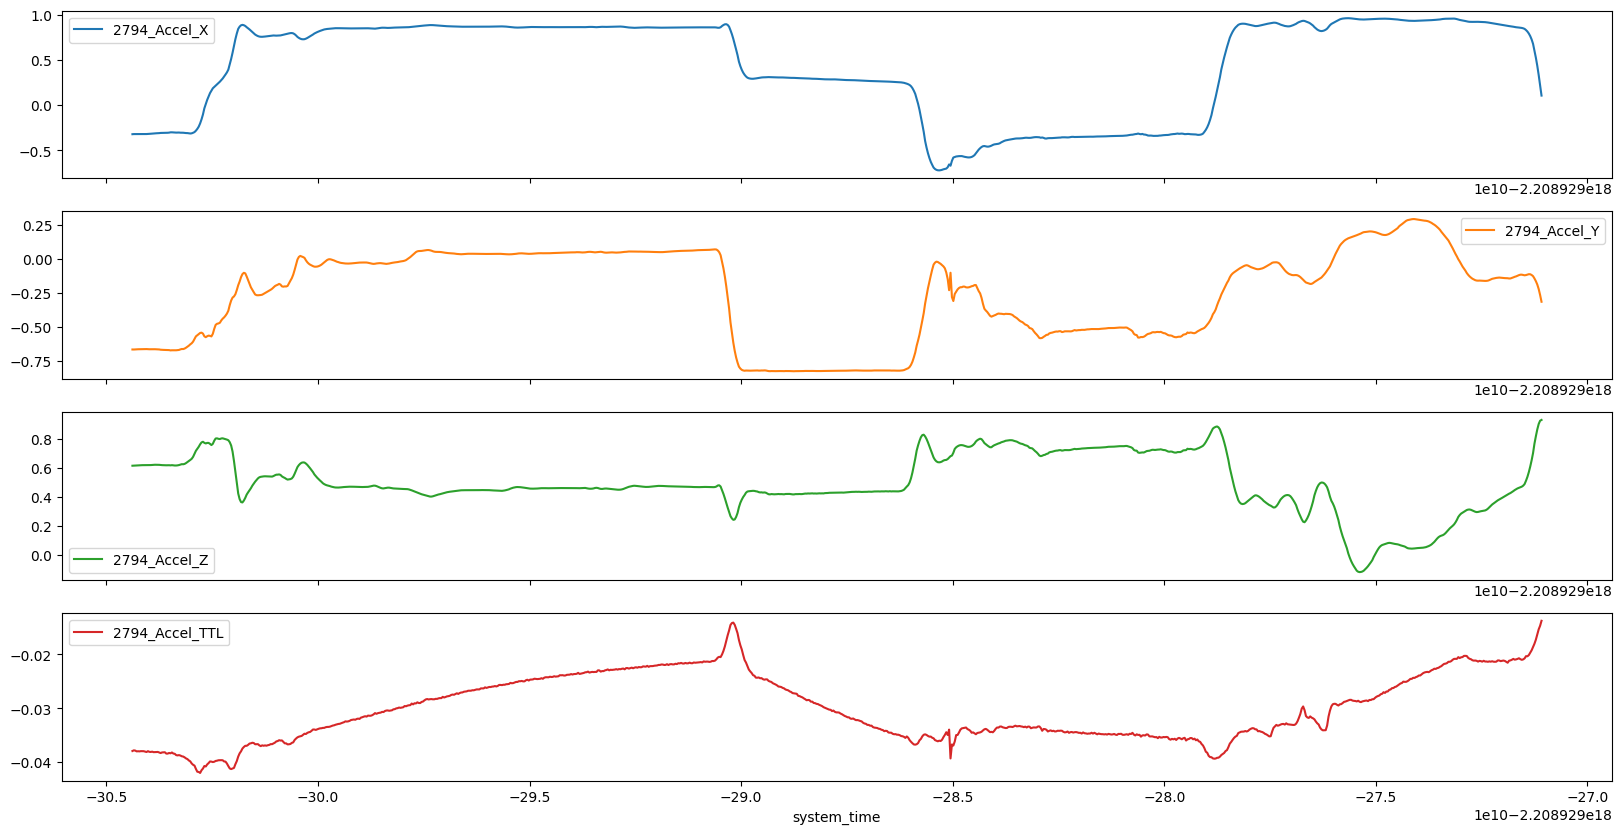

In [46]:
# the datetimeindex plotting is super slow, much faster if converted to int64
df_all.index = pd.to_numeric(df_all.index, errors='coerce')
display(df_all.head())
df_all.info()
df_all.iloc[999:1999].plot(subplots=True, figsize=(20, 10)) # yay Pandas

array([<Axes: xlabel='system_time'>, <Axes: xlabel='system_time'>,
       <Axes: xlabel='system_time'>, <Axes: xlabel='system_time'>],
      dtype=object)

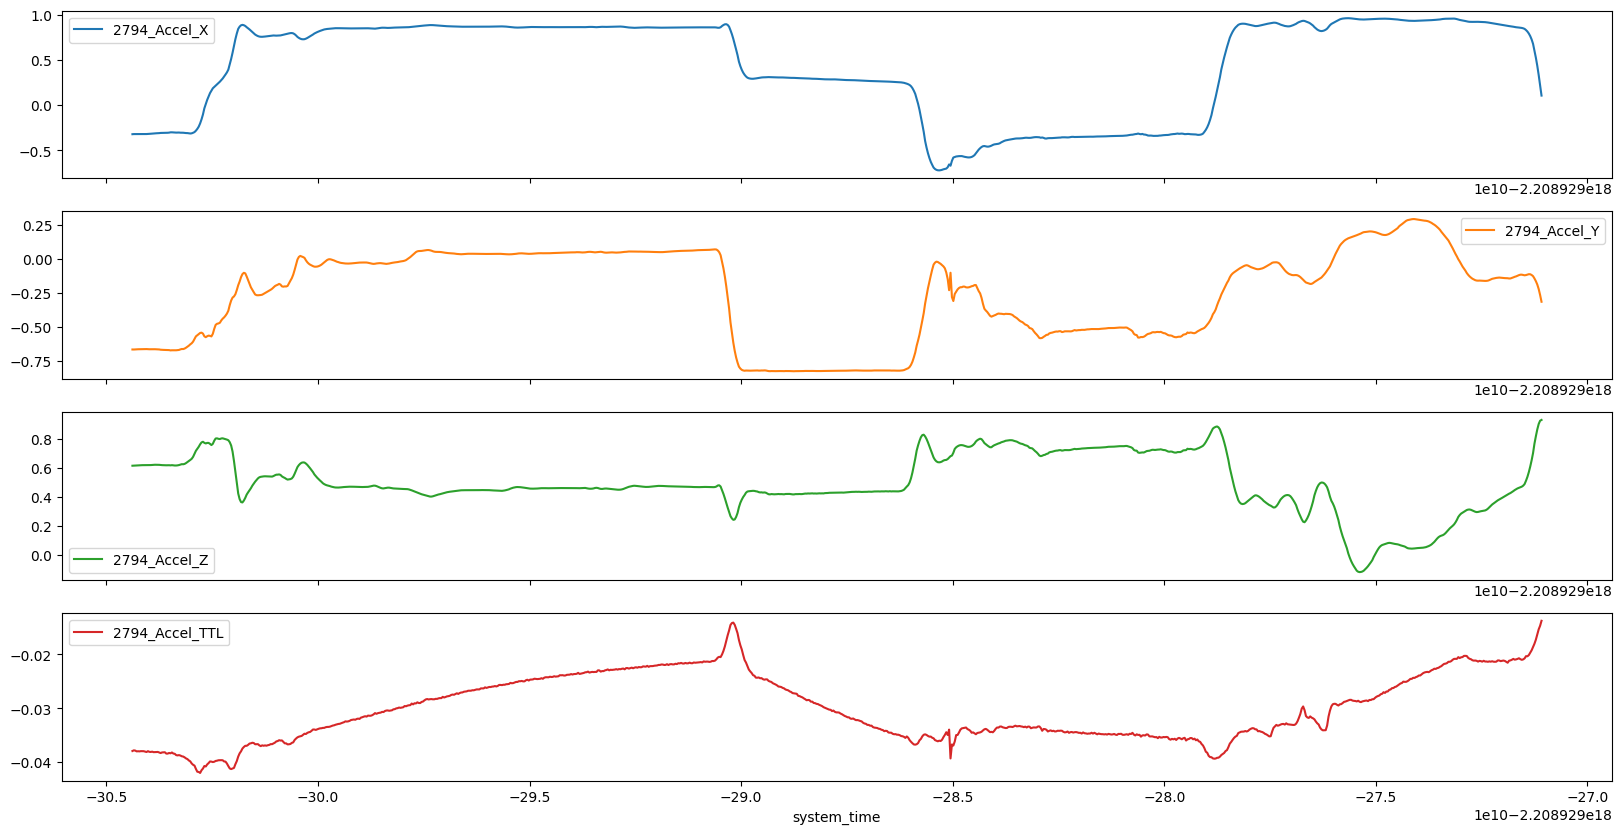

In [44]:
df_all.iloc[999:1999].plot(subplots=True, figsize=(20, 10)) # yay Pandas

In [21]:
def get_cmu_mocap_ir1_dict():
    """reads the CMU Motion Cap dataset brownie files and converts to an IR1
    dataframe.  The goal here is to capture and convert all raw data into
    a 2D dataframe of rows = datetime index of each sample, columns = {channels,
    label(s), subject_num}.  Additional methods may be used to drop channels,
    and convert the string labels to mapped ints prior to switch to ndarrays.
    Args:
    none but uses global scripted (boolean):
    Returns: a dict containing key = df_name and item = IR1 dataframes."""
    print("Building dictionary of IR1 dataframes, with downloads this takes ~15 minutes to run")
    ir1_df_dict = dict() # an empty dictionary
    for key in subjects:
        ir1_fname = key+'_Brownie_3DMGX1'
        print('Processing',ir1_fname)
        df = get_cmu_imu_df(sub_key = key)
        ir1_df_dict[ir1_fname]=df
    return ir1_df_dict
if interactive:
    verbose = False
    ir1_dict = get_cmu_mocap_ir1_dict()
    print('IR1 dataframes:',ir1_dict.keys())
    for df_name, df in ir1_dict.items():
        display(df.head())
        break # just want one

In [22]:
# No idea why this takes so long to plot with just 3 channels and 1K rows
# df[['2794_Accel_X','2794_Accel_Y','2794_Accel_Z']].iloc[999:1999].plot(subplots=True, figsize=(20, 10)) # yay Pandas

# Main is setup to be a demo and bit of unit test.

In [23]:
verbose = False # otherwise a lot of output from main.

In [24]:
if __name__ == "__main__":
    print("Get dictionary of IR1 dataframes, this takes ~15 minutes to run with downloads")
    ir1_dict = get_cmu_mocap_ir1_dict()
    print('IR1 dataframes:',ir1_dict.keys())
    for df_name, df in ir1_dict.items():
        print(df.head())
        break # just want one


Get dictionary of IR1 dataframes, this takes ~15 minutes to run
Processing S07_Brownie_3DMGX1
Processing S08_Brownie_3DMGX1
Processing S09_Brownie_3DMGX1
Processing S12_Brownie_3DMGX1
Processing S13_Brownie_3DMGX1
Processing S14_Brownie_3DMGX1
Processing S16_Brownie_3DMGX1
Processing S17_Brownie_3DMGX1
Processing S18_Brownie_3DMGX1
Processing S19_Brownie_3DMGX1
Processing S20_Brownie_3DMGX1
Processing S22_Brownie_3DMGX1
Processing S24_Brownie_3DMGX1
IR1 dataframes: dict_keys(['S07_Brownie_3DMGX1', 'S08_Brownie_3DMGX1', 'S09_Brownie_3DMGX1', 'S12_Brownie_3DMGX1', 'S13_Brownie_3DMGX1', 'S14_Brownie_3DMGX1', 'S16_Brownie_3DMGX1', 'S17_Brownie_3DMGX1', 'S18_Brownie_3DMGX1', 'S19_Brownie_3DMGX1', 'S20_Brownie_3DMGX1', 'S22_Brownie_3DMGX1', 'S24_Brownie_3DMGX1'])


,2794_Accel_X,2794_Accel_Y,2794_Accel_Z,2794_Roll,2794_Pitch,2794_Yaw,2794_Mag_X,2794_Mag_Y,2794_Mag_Z,2795_Accel_X,...,3337_Accel_Y,3337_Accel_Z,3337_Roll,3337_Pitch,3337_Yaw,3337_Mag_X,3337_Mag_Y,3337_Mag_Z,label,sub
system_time,,,,,,,,,,,,,,,,,,,,,
1900-01-01 16:31:02.317625,0.243538,-0.407819,0.843623,0.013492,-0.003138,0.013179,-0.630127,0.301392,-1.026489,0.942747,...,0.822474,0.552873,-0.005020,0.008158,0.004393,-0.350830,-0.963013,-0.650269,unknown,7
1900-01-01 16:31:02.350957,0.243538,-0.407605,0.843623,0.004393,0.012865,-0.007844,-0.630127,0.301147,-1.026489,0.943388,...,0.822474,0.552873,0.007531,0.010041,0.001883,-0.350708,-0.963013,-0.650269,unknown,7
1900-01-01 16:31:02.384289,0.243538,-0.407819,0.843623,0.005334,-0.005020,-0.001255,-0.630127,0.301270,-1.026611,0.944243,...,0.822474,0.552660,0.005962,0.001255,0.011610,-0.350708,-0.963013,-0.650269,unknown,7
1900-01-01 16:31:02.417621,0.243751,-0.407819,0.843410,0.013492,-0.003138,-0.003765,-0.630371,0.301392,-1.026367,0.945097,...,0.822474,0.552660,0.011610,0.002510,0.000941,-0.350952,-0.963013,-0.650146,unknown,7
1900-01-01 16:31:02.450953,0.243965,-0.407178,0.843623,0.001883,-0.011923,-0.008158,-0.630615,0.300537,-1.026489,0.945311,...,0.822687,0.552446,-0.002824,-0.001883,0.010041,-0.351074,-0.963013,-0.650024,unknown,7
